# Analyze adsorption isotherm anomalies

In [89]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import pygaps
import scipy

## Lets make a Python class for an adsorption isotherm

### This is usually referred to as class-based Object-Oriented Programming (OOP). 

#### [Here](https://pythonprogramming.net/introduction-learn-python-3-tutorials/)'s a tutorial series on Python if you want to learn the basics, and [Here](https://pythonprogramming.net/introduction-intermediate-python-tutorial/)'s an intermediate Python tutorial if the basic one is too easy.

#### More specifically, [This](https://pythonprogramming.net/object-oriented-programming-introduction-intermediate-python-tutorial/) is a tutorial on OOP in Python that I recommend, which introduces Classes

In [90]:
class Isotherm:
    # In Python classes, there is one required function you have to define, __init__ (for initialization)
    def __init__(self, filename):
        # This if-else sentence loads in the isotherm data. If you have extracted the isotherms into your directory, 
        #  you will load it directly, but if you haven't you'll have to download it from the NIST database.
        if os.path.isfile('isotherms/' + filename + '.json'):
            with open('isotherms/' + filename + '.json') as infile:
                isotherm_data = json.load(infile)
        else:
            url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
            isotherm_data = json.loads(requests.get(url).content)

        
        self.filename = filename
        self.doi = isotherm_data['DOI']
        assert len(isotherm_data['adsorbates']) < 2
        self.adsorbate = isotherm_data['adsorbates'][0]['name']
        self.inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        self.adsorbent = isotherm_data['adsorbent']['name']
        self.category = isotherm_data['category']
        self.temperature = isotherm_data['temperature']
        self.adsorptionUnits = isotherm_data['adsorptionUnits']
        self.pressureUnits = isotherm_data['pressureUnits']
        self.pressure = np.array([isotherm_data['isotherm_data'][i]['pressure'] for i in range(len(isotherm_data['isotherm_data']))])
        self.adsorption = np.array([isotherm_data['isotherm_data'][i]['species_data'][0]['adsorption'] for i in range(len(isotherm_data['isotherm_data']))])
        self.henry_constant = None
        
    # Lets define a few helper functions first
    def _get_formula_from_inchikey(self):
        # Usually if there's an underscore in front of a function name, 
        #  it's meant for internal use
        url = "https://adsorbents.nist.gov/isodb/api/gas/" + self.inchikey + ".json"
        gas_data = json.loads(requests.get(url).content)
        self.formula = gas_data['formula']
    
    def get_molecular_weight(self):
        self._get_formula_from_inchikey()
        # We will need to read in the atomic masses to compute the molecular weight (mw):
        atomic_masses = pd.read_csv('data/atomicmasses.csv')
        
        # This splits the formula up into elements plus their frequency
        start_i = 0
        elements = []
        for end_i, letter in enumerate(self.formula[1:], start=1):
            if letter.isupper():
                elements.append([start_i, end_i])
                start_i = end_i
        elements.append([start_i, len(self.formula)])

        # This calculates the molecular weight of each type of element
        self.mw = 0
        for element in elements:
            form = self.formula[element[0]:element[1]]
            for i, letter in enumerate(form):
                if letter.isdigit():
                    element_mw = np.float(atomic_masses[atomic_masses.atom == form[:i]]['mass'])
                    self.mw = self.mw + element_mw * np.int(form[i:])
                    break
                if form.isalpha():
                    element_mw = np.float(atomic_masses[atomic_masses.atom == form]['mass'])
                    self.mw = self.mw + element_mw
                    break
        return self.mw
        
    def convert_units(self):
        # This will convert the pressure and adsorption to 'bar' and 'mmol/g', respectively, if needed
        # Pressure Units:
        assert self.pressureUnits == 'bar'

        # Adsorption Units:
        assert self.adsorptionUnits in ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']

        aConversion = 0.0
        if self.adsorptionUnits == 'mmol/g':
            aConversion = 1.0
        elif self.adsorptionUnits == 'mmol/kg':
            aConversion = 1.0 / 1000.0
        elif self.adsorptionUnits == 'mol/g':
            aConversion = 1000.0
        elif self.adsorptionUnits in ['wt%', 'g/g']:
            mw = self.get_molecular_weight()
            aConversion = 1000.0 / mw
        elif self.adsorptionUnits in ['ml/g', 'cm3(STP)/g']:
            aConversion = 1.0 / 22.4
        elif self.adsorptionUnits == 'mg/g':
            mw = self.get_molecular_weight()
            aConversion = 1.0 / mw
        else:
            raise Exception('Something went horribly wrong!')

        self.adsorption = self.adsorption * aConversion
        self.adsorptionUnits = 'mmol/g'
        
    def fit_henry_constant(self, max_adjrms, verbose):
        # This will fit a Henry constant to the adsorption isotherm.
        # `max_adjrms` is a parameter used for the fitting procedure. 
        #  The default value is 0.01, but we can play around with this.
        # `verbose=True` will create a plot of the fit and give additional information
        # If the adsorption units are not in 'mmol/g' and the pressure units are not in 'bar',
        #  the assertion below will throw an error. Use `convert_units` to switch to the correct units
        assert self.adsorptionUnits == 'mmol/g' and self.pressureUnits == 'bar'
        isotherm = pygaps.PointIsotherm(
            pressure=self.pressure,
            loading=self.adsorption,
            material_name=self.adsorbent,
            material_batch='',
            t_iso=self.temperature,
            adsorbate=self.adsorbate)
        try:
            self.henry_constant = pygaps.initial_henry_slope(isotherm, max_adjrms, logx=False, verbose=verbose)
            return self.henry_constant
        except Exception as e:
            self.error = e
            print('Fitting procedure failed! See `self.error` as to why...')
            
    def flag_isotherm(self, henry_df):
        henry_df['ok'].loc[henry_df['filename'] == self.filename] = False
        return
    
    def unflag_isotherm(self, henry_df):
        henry_df['ok'].loc[henry_df['filename'] == self.filename] = True
        return
    
    def add_comment(self, comment, henry_df):
        henry_df['comment'].loc[henry_df['filename'] == self.filename] = comment
        return
    
    def plot_isotherm(self):
        fig = plt.figure(figsize=(8,6))
        bad_datapoints = self.pressure[self.pressure < 0]
        good_datapoints = self.pressure[self.pressure >= 0]
        plt.scatter(self.pressure, self.adsorption, marker='o', label='Experimental')
        if self.henry_constant:
            plt.plot([0, self.pressure[-1]], [0, self.pressure[-1] * self.henry_constant], color='red', label="Henry's Law")
        plt.xlabel('Pressure [{}]'.format(self.pressureUnits))
        plt.ylabel('Adsorption [{}]'.format(self.adsorptionUnits))
        plt.ylim([-0.2*self.adsorption[-1], self.adsorption[-1] * 1.2])
        plt.legend()
        plt.show()
        return

In [91]:
henry_df = pd.read_csv('henry_df.csv')
henry_df.head(10)

,Unnamed: 0,gas,material,henry_constant,filename,ok,z_score,comment
0,0,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.466816,10.8888s10450-012-9407-1.Isotherm11,True,0.060536,NaN
1,1,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.953870,10.8888s10450-012-9407-1.Isotherm1,True,0.060520,NaN
2,2,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.290830,10.8888jp206959k.Isotherm17,True,0.060542,NaN
3,3,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.612494,10.8888Ja909263x.Isotherm2,True,0.060467,NaN
4,4,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.962891,10.8888j.cej.2011.01.096.isotherm4b,True,0.060520,NaN
5,5,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.661777,10.1039C4ee01009d.Isotherm22,True,0.060465,NaN
6,6,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.136735,10.1039C4ee01009d.Isotherm21,True,0.060482,NaN
7,7,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.434755,10.1039C4ee01009d.Isotherm20,True,0.060473,NaN
8,8,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.297005,10.1039C4ee01009d.Isotherm19,True,0.060509,NaN
9,9,CURLTUGMZLYLDI-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.263696,10.1039C4ee01009d.Isotherm18,True,0.060510,NaN


In [92]:
henry_df.sort_values(["henry_constant"], ascending = False, inplace = True)
henry_df.head(100)

,Unnamed: 0,gas,material,henry_constant,filename,ok,z_score,comment
961,961,UGFAIRIUMAVXCW-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,6.401857e+13,10.1016j.micromeso.2012.02.034.Isotherm2,False,8.246211,NaN
1560,1560,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,3.662595e+09,10.1016j.fluid.2014.08.020.Isotherm3,False,15.789991,NaN
1190,1190,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,2.593508e+09,10.1016j.fluid.2014.08.020.Isotherm2,False,11.158472,NaN
1191,1191,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,2.485209e+09,10.1016j.fluid.2014.08.020.Isotherm1,False,10.689296,NaN
1847,1847,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,3.377586e+08,10.1007s11224-012-0120-1.isotherm35,False,5.058808,NaN
1821,1821,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,1.527369e+08,10.1007s11224-012-0120-1.isotherm36,True,2.145248,NaN
1849,1849,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,9.760917e+06,10.1007s11224-012-0120-1.isotherm32,True,0.106214,NaN
1822,1822,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,9.610024e+06,10.1007s11224-012-0120-1.isotherm34,True,0.108590,NaN
1848,1848,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-297c8ffe0f482757db45335130e02770,9.362430e+06,10.1007s11224-012-0120-1.isotherm33,True,0.112489,NaN
1823,1823,HSFWRNGVRCDJHI-UHFFFAOYSA-N,NIST-MATDB-1733c0f5ae26290495f099f06d0dd880,8.959582e+06,10.1007s11224-012-0120-1.isotherm31,True,0.118833,NaN


In [93]:
henry_df.loc[np.isnan(henry_df['henry_constant'])]

,Unnamed: 0,gas,material,henry_constant,filename,ok,z_score,comment
120,120,UFHFLCQGNIYNRP-UHFFFAOYSA-N,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,NaN,10.1021Jp074889i.Isotherm69,False,NaN,NaN
243,243,QGZKDVFQNNGYKY-UHFFFAOYSA-N,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,NaN,10.1021je000273plus.isotherm83,False,NaN,NaN
244,244,QGZKDVFQNNGYKY-UHFFFAOYSA-N,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,NaN,10.1021je000273plus.isotherm82,False,NaN,NaN
246,246,QGZKDVFQNNGYKY-UHFFFAOYSA-N,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,NaN,10.1021je000273plus.isotherm76,False,NaN,NaN
350,350,IJGRMHOSHXDMSA-UHFFFAOYSA-N,NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,NaN,10.1039C1cc14685h.Isotherm6,False,NaN,NaN
719,719,IJGRMHOSHXDMSA-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1021Je1002225.isotherm12,False,NaN,NaN
748,748,VNWKTOKETHGBQD-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1039C4ra12432d.Isotherm5,False,NaN,NaN
894,894,UFHFLCQGNIYNRP-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1016j.fluid.2013.11.029.Isotherm49,False,NaN,NaN
895,895,UFHFLCQGNIYNRP-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1016j.egypro.2011.01.090.Isotherm1,False,NaN,NaN
975,975,XKRFYHLGVUSROY-UHFFFAOYSA-N,NIST-MATDB-991daf7313251e7e607e2bab2da57e33,NaN,10.1039C1cp20168a.Isotherm10,False,NaN,NaN


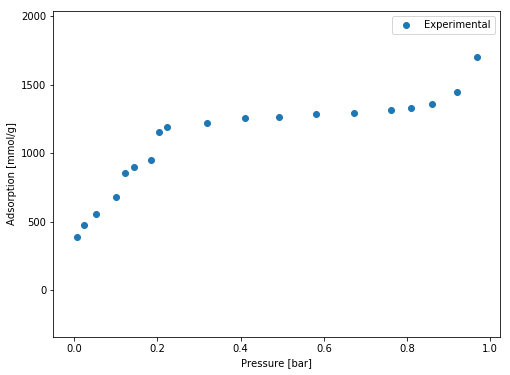

Calculated K = 69111.87562907842
Starting points: 20
Selected points: 2
Final adjusted root mean square difference: 0.0


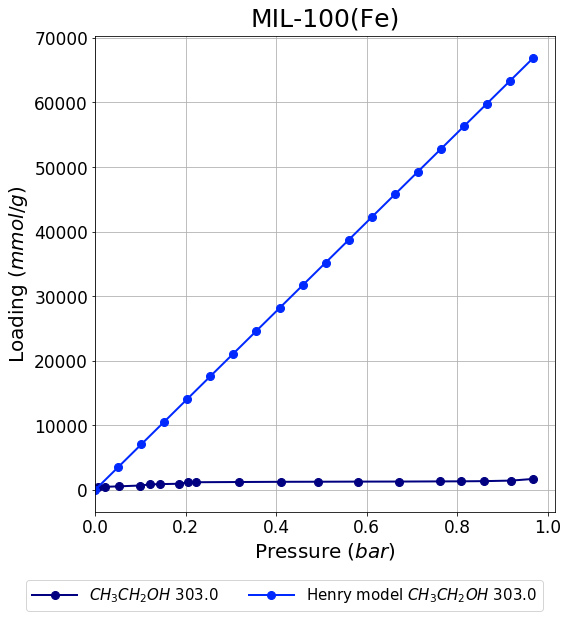

C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


array([0.00561856, 0.02252   , 0.0535059 , 0.0999848 , 0.121112  ,
       0.143647  , 0.184492  , 0.20421   , 0.22252   , 0.318295  ,
       0.409844  , 0.492943  , 0.580266  , 0.671816  , 0.761957  ,
       0.808435  , 0.85914   , 0.919703  , 0.96759   ])

In [94]:
bad_iso2 = Isotherm('10.1016j.micromeso.2012.02.027.isotherm7')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Original units in P/P0 -- should recheck unit conversion', henry_df)
bad_iso2.pressure

In [95]:
bad_iso2.adsorption

array([ 388.30921993,  476.97295589,  556.46121293,  678.7531768 ,
        856.07630734,  895.8215212 ,  950.85268787, 1155.69357243,
       1189.32397103, 1222.95436963, 1253.52627525, 1265.75590578,
       1284.10035156, 1293.27148911, 1317.72857948, 1329.95821   ,
       1357.47379334, 1443.07903632, 1699.89259458])

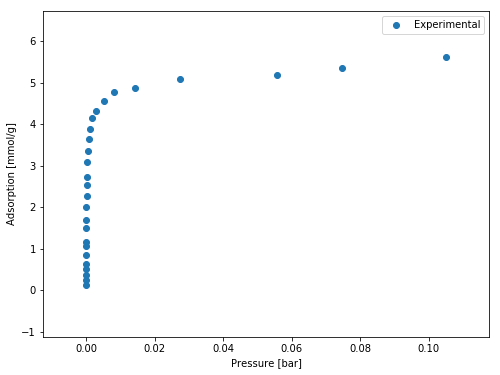

Calculated K = 109417.46177349259
Starting points: 28
Selected points: 4
Final adjusted root mean square difference: 0.002275135551331488


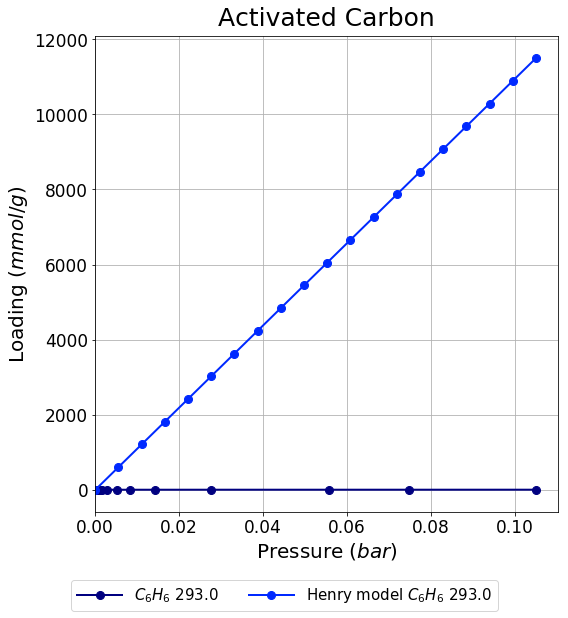

array([1.04000e-06, 2.36000e-06, 3.40000e-06, 6.87000e-06, 9.23000e-06,
       1.11000e-05, 1.39000e-05, 1.95000e-05, 2.94000e-05, 3.86000e-05,
       6.23000e-05, 1.00000e-04, 1.41000e-04, 1.90000e-04, 3.27000e-04,
       4.92000e-04, 7.94000e-04, 1.19476e-03, 1.68007e-03, 2.83357e-03,
       5.11622e-03, 8.24549e-03, 1.42263e-02, 2.74991e-02, 5.56267e-02,
       7.47466e-02, 1.05109e-01])

In [96]:
bad_iso2 = Isotherm('10.1021la010232r.Isotherm2')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Benzene adsorption, low pressure isotherm', henry_df)
bad_iso2.pressure

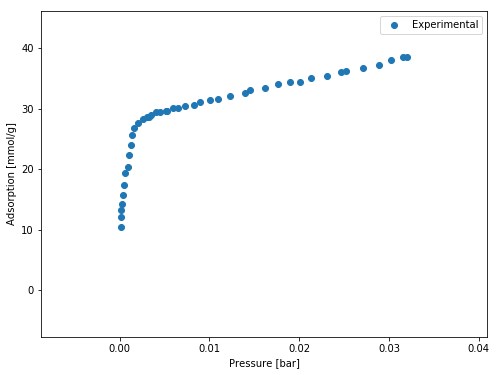

Calculated K = 63137.68122822176
Starting points: 45
Selected points: 2
Final adjusted root mean square difference: 0.0


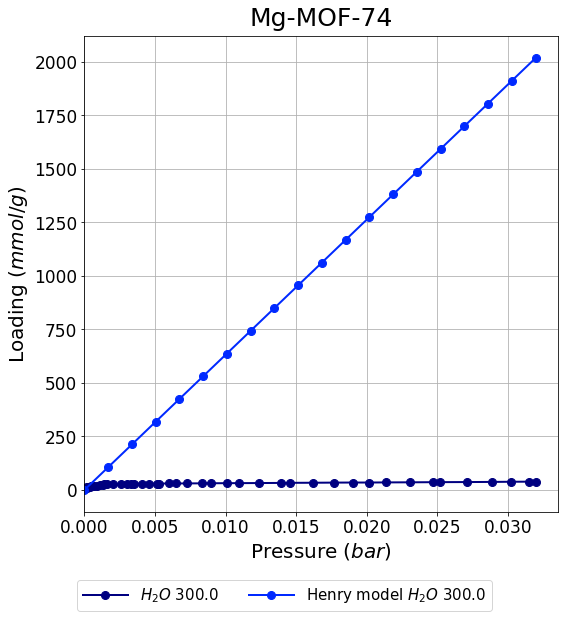

array([0.00021065, 0.00021148, 0.00021258, 0.0002649 , 0.00037382,
       0.0004826 , 0.00064605, 0.00092009, 0.00108354, 0.00130221,
       0.00141099, 0.00162994, 0.00201401, 0.00261799, 0.00300233,
       0.00327705, 0.00349655, 0.00410067, 0.00454023, 0.00514449,
       0.00525438, 0.00596839, 0.00646289, 0.00723185, 0.00833061,
       0.00893473, 0.0100883 , 0.0109673 , 0.0123406 , 0.0139336 ,
       0.0145377 , 0.0161858 , 0.0176689 , 0.0189873 , 0.0201412 ,
       0.0213495 , 0.0230526 , 0.0247005 , 0.0251949 , 0.0271177 ,
       0.0288755 , 0.0301936 , 0.031512  , 0.0319516 ])

In [97]:
bad_iso2 = Isotherm('10.1021Jp503778m.Isotherm7')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Water adsorption, non linear plot points on x axis', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

array([13.2997, 12.0907, 10.4786, 14.3073, 15.7179, 17.33  , 19.3451,
       20.3526, 22.3678, 23.9798, 25.5919, 26.801 , 27.6071, 28.2116,
       28.6146, 28.6146, 29.0176, 29.4207, 29.4207, 29.6222, 29.6222,
       30.0252, 30.0252, 30.4282, 30.6297, 31.0327, 31.4358, 31.6373,
       32.0403, 32.6448, 33.0479, 33.4509, 34.0554, 34.4584, 34.4584,
       35.063 , 35.466 , 36.0705, 36.272 , 36.6751, 37.2796, 38.0856,
       38.4887, 38.4887])

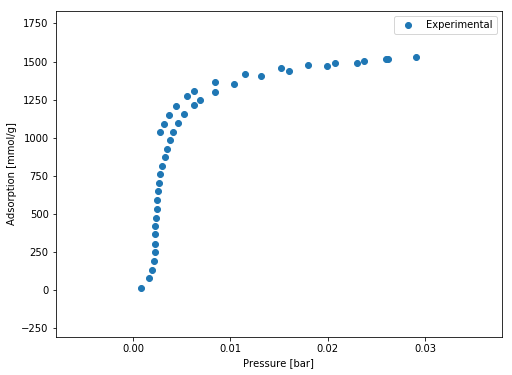

In [ ]:
bad_iso2 = Isotherm('10.1002anie.201506345.Isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Bad plot points completely off trend. Likely plotted desorption and adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2 = Isotherm('10.1016j.egypro.2009.01.166.Isotherm6')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2 = Isotherm('10.1252Jcej.37.67.isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2 = Isotherm('10.1021Je800900a.Isotherm53')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2 = Isotherm('10.1039c5cc00113g.Isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('propanol adsorption, low pressures', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2 = Isotherm('10.1021Jp1033273.Isotherm15')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2 = Isotherm('10.1021Jp805923k.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2 = Isotherm('10.1039C2dt31112g.Isotherm10')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Created new plot points, high KH likely due to adsorption of water', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039C3ce26788a.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Created new plot points high KH likely due to water adsorption, paper gives no indication of pressure range used-- is P0 a universal constant-- gas dependent. Extra # of plot points added not similar to lit.', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016j.ces.2010.10.002.isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Units converted from RH% at 25C to bar, High KH from water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039C3cc48275h.Isotherm20')
print(bad_iso2.adsorption)
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(0.01, True)
bad_iso2.add_comment('Fourth point incorrectly plotted by exceeding x-coordinate of two points above its y-coordinate, y-axis in wt% of benzene, negative adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039c5cc00113g.Isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('The adsorption curve shows a sudden increase in uptake at a relative pressure (P/P0) of 0.15 reaching the first saturation capacity of 7.8 wt%. At a relative pressure (P/P0) of 0.27, TetZB shows another step adsorption reaching the second saturation capacity of 26 wt% or 4.55 mmol g−1-- Units for adsorption may be converted incorrectly.', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016j.micromeso.2012.02.027.isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Ethanol yields three-step isotherms, with two step isotherms at very low p/p0., # of plot points do not correspond with literature,-- not sure if MIL-100(Fe)_F or MIL-100(Fe)_NF7 ', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016S1004-9541(07)60095-0.Isotherm10-1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Second plot point not linear on x-coordinate, literature indicates different ZSM-5 samples, but no way to determine which curve was used. Additionally, literature indicates mmol g-1, but .json indicates wt%. ', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Ct500094w.Isotherm4')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Large KH likely due to water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021la010232r.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Original literature in log scale and pascals. Not sure what is wrong', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Jp1033273.Isotherm16')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Plot likely taken from fig. 5 adsorption isotherms for equimolar mixtures of water/ethanol while on a log scale', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039C4cs00078a.Isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Original lit. units in PH2O/PsatH2O. High KH likely due to water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039C1cp20502a.Isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Cant find the propene adsorption isotherm in the literature. I believe this may be from the propyne isotherm adsorption. Original units are in torr and isotherm was measured during extremely low pressure (0-0.3 torr)', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021la010232r.Isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Original literature in log scale and pascals. There are two isotherms measuring the same mof and adsorbent at same temp (10.1021la010232r.Isotherm1) Not sure what is wrong', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039c5cc00113g.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('P/P0 scale on the same plot. Wt% on y axis', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Jp805923k.Isotherm2')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Water adsorption, on P/Psat scale', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016j.ces.2010.10.002.isotherm6')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('x axis measured with relative humidity, water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016j.micromeso.2012.02.027.isotherm8')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Does not include same number of data points as literature. P/P0 scale', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016j.cej.2011.07.051.Isotherm3')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('"The high regression coefficient R2 up to 0.997 indicates that the L-F model gives a good fit to the experimental isotherm of p-xylene on the MIL-101 samples. At low adsorbate concentrations the L-F model can effectively reduce to a Freundlich isotherm and thus does not obey Henrys law.-- solid curves, model fitting by Langmuir-Fruendlich equation)."', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Ja060946u.Isotherm11')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('P/P0 scale, water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016j.cej.2011.07.051.Isotherm3-1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('"The high regression coefficient R2 up to 0.997 indicates that the L-F model gives a good fit to the experimental isotherm of p-xylene on the MIL-101 samples. At low adsorbate concentrations the L-F model can effectively reduce to a Freundlich isotherm and thus does not obey Henrys law.-- solid curves, model fitting by Langmuir-Fruendlich equation).', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1252Jcej.37.67.isotherm4')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Extremely steep initial slope', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039C1cp20502a.Isotherm6')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('Incredibily low pressure data points only', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Ct500094w.Isotherm5')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Jp805923k.Isotherm3-1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('ethanol adsorption, low pressures, extremely high initial slope', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039c5cc00113g.Isotherm2')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('methanol adsorption, low pressures', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Jp805923k.Isotherm2-2')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption, low pressures, high intial slope', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016j.ces.2010.10.002.isotherm7')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1016S0009-2509(00)00531-5.Isotherm8')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Ie202325p.Isotherm1')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1039C1cp20502a.Isotherm7')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('cyclopropane adsorption, incorrect pressure scale (c3h6 has vapor pressure of 5.41e03mmHg = ~7.2bar)', henry_df)
bad_iso2.pressure

In [ ]:
bad_iso2.adsorption

In [ ]:
bad_iso2 = Isotherm('10.1021Ct500094w.Isotherm6')
bad_iso2.convert_units()
bad_iso2.plot_isotherm()
bad_iso2.pressure = bad_iso2.pressure #* 1e10
bad_iso2.fit_henry_constant(1e100, True)
bad_iso2.add_comment('water adsorption', henry_df)
bad_iso2.pressure